In [16]:
#General Libraries for 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error
import statsmodels.tsa.statespace.sarimax
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [2]:
df = pd.read_csv('zillow_data.csv')

# Step 2: Data Preprocessing

In [4]:
def get_datetimes(df):
 
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [5]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Step 3: EDA and Visualization

In [6]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [7]:
def melt_total_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted .groupby('time').aggregate({'value':'mean'})

In [8]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

# Step 5: ARIMA Modeling

In [9]:
#Create Initial Dataframe for Model

total_df = melt_total_data(df)

<AxesSubplot:xlabel='time'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


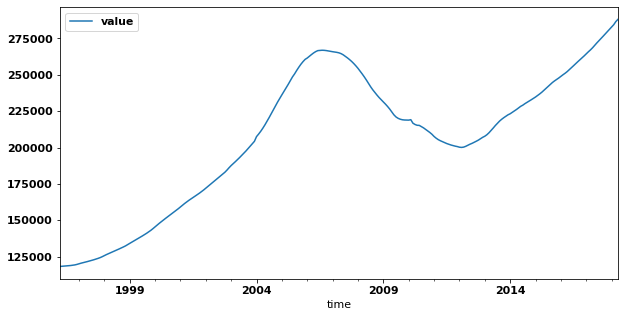

In [10]:
#Plot Model to Determine potential patterns

total_df.plot(figsize=(10,5))

In [11]:
#Conducting Dickey Fuller Test to Determine Stationarity

def adtest(frame):
    dickeyfuller = adfuller(frame)
    ad_results = pd.DataFrame(dickeyfuller[0:4], index=['Test Statistic',
                                           'p-value',
                                           '# Lags Used',
                                           'Number of Observations Used'])
    
    return ad_results.loc['p-value']

adtest(total_df)

0    0.339082
Name: p-value, dtype: float64

In [12]:
#Due to Dickey Fuller test returning a P Value greater than 0.05, differencing will be put in place

good_diff_values = []

for n in range(1, 60, 1):
    total_df_diff = total_df.diff(n).dropna()
    p_val = adtest(total_df_diff)
    if p_val[0] < 0.051:
        good_diff_values.append([n, p_val[0]])

differencing_vals = pd.DataFrame(good_diff_values).sort_values(by=0, ascending = True)

differencing_vals.head()

,0,1
0,19,0.017197
1,20,0.009884
2,21,0.021668
3,22,0.015678
4,23,0.022229


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


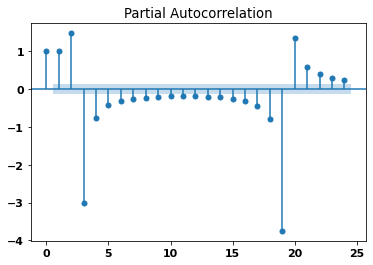

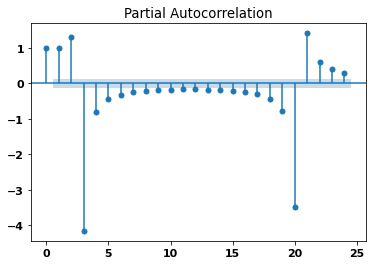

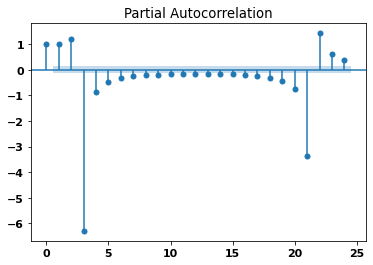

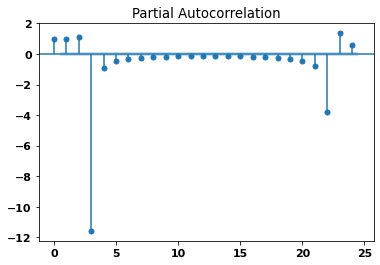

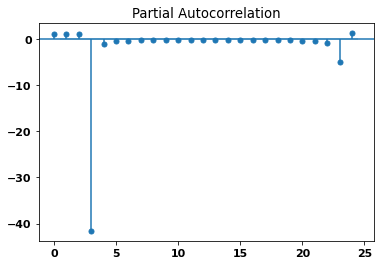

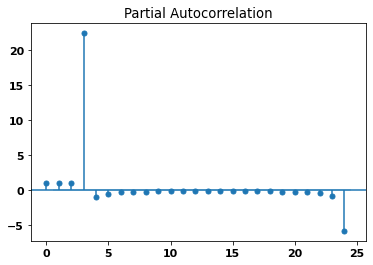

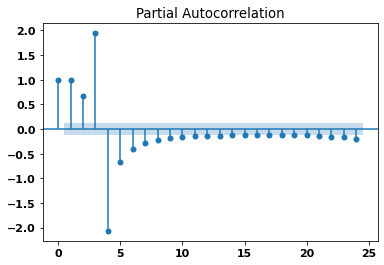

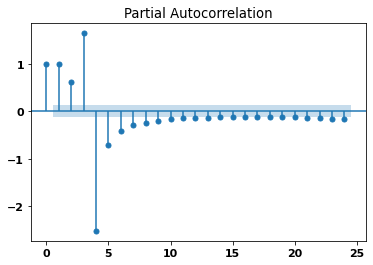

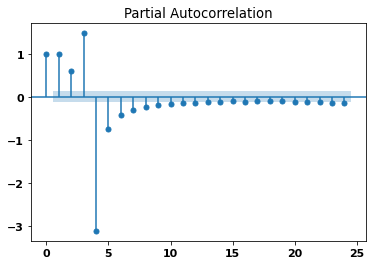

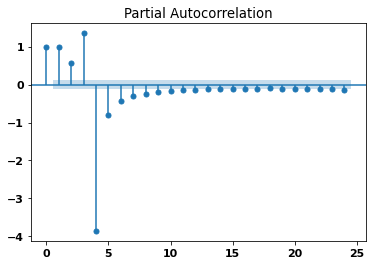

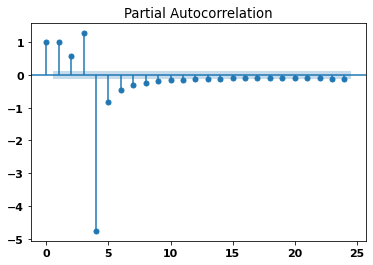

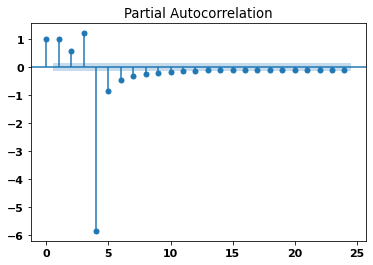

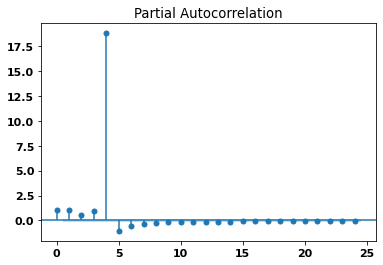

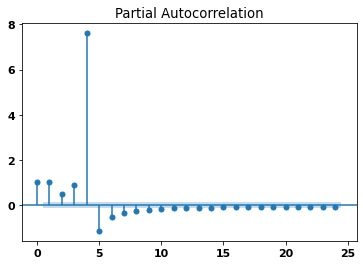

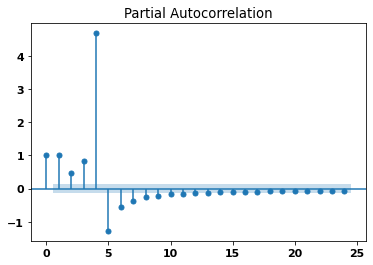

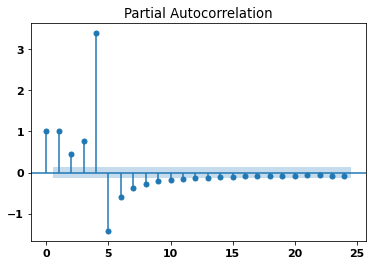

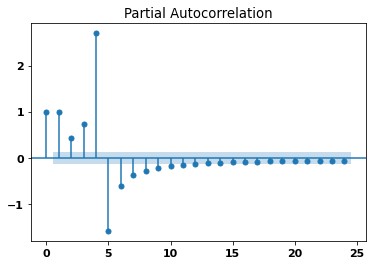

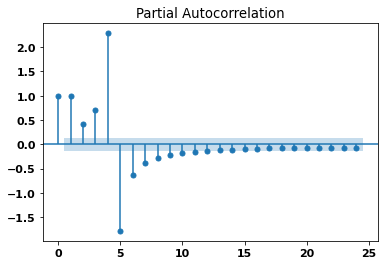

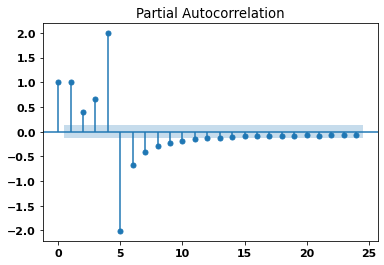

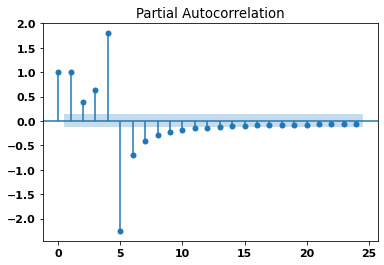

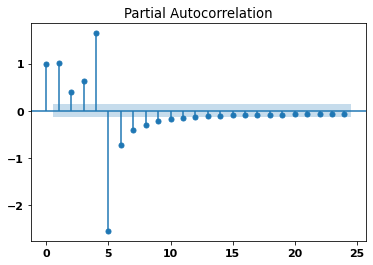

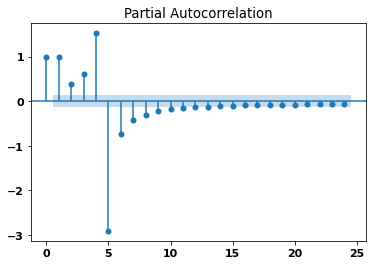

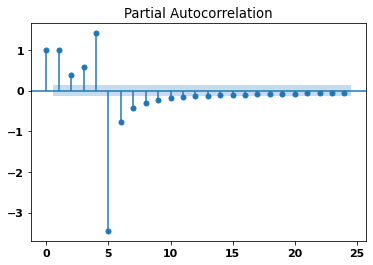

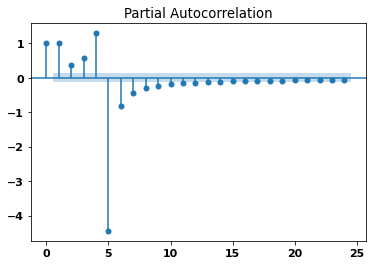

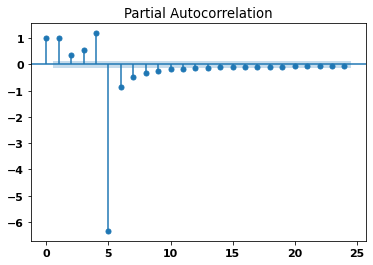

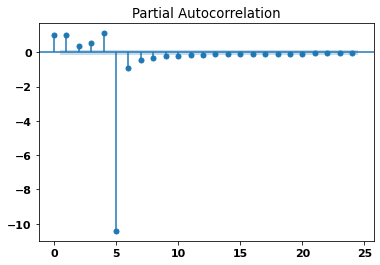

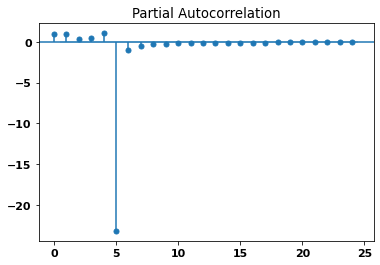

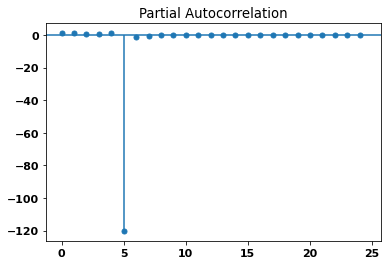

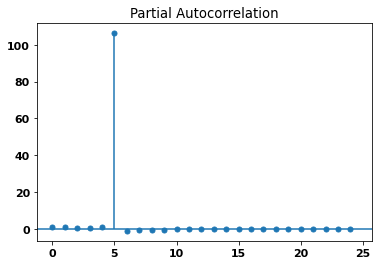

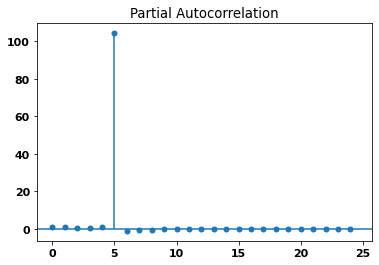

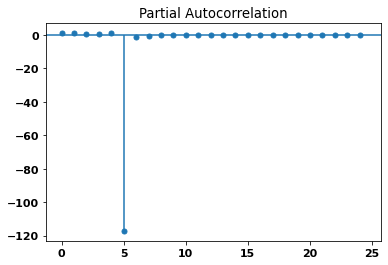

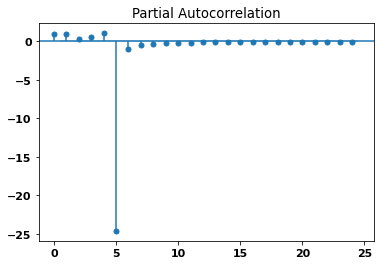

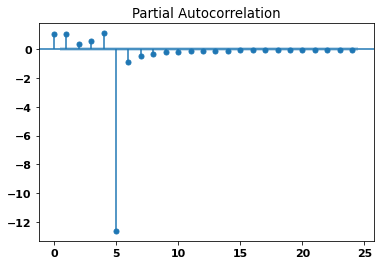

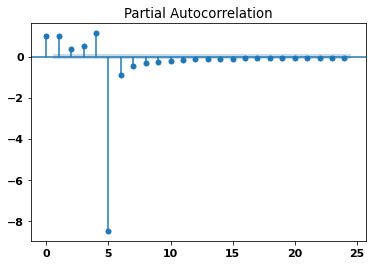

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for item in differencing_vals[0]:
    plot_pacf(total_df.diff(item).dropna());
    # plot_pacf(total_df.diff(19).dropna());

In [14]:
#Splitting Train and Test Data

X_train = total_df.head(265-12)
y_train = total_df.tail(12)

In [17]:
#Iterate through potential pdq values for total dataset

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,4,1)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
# #Ascertain Best Combos

# from sklearn.metrics import mean_absolute_error

# import statsmodels

# best_iteration = []

# for combo in pdq:
#     for seasonal_combo in pdqs:
#         final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
#                                                                  order = combo,
#                                                                  seasonal_order = seasonal_combo,
#                                                                  enforce_stationarity = False,
#                                                                  enforce_invertibility = False)

#         final_model_fit = final_model.fit()

#         preds = final_model_fit.get_forecast(steps = 12)

#         preds = preds.summary_frame()[['mean']]

#         mae = mean_absolute_error(preds, y_train)

#         comp_error = mae / int(y_train.tail(1)['value'])

#         best_iteration.append([combo, seasonal_combo, mae, comp_error])
        
#         print([combo, seasonal_combo, mae, comp_error])

In [19]:
# #Ascertain Best Combination:

# best_iteration = pd.DataFrame(best_iteration)

# best_iteration.columns = ['pdq', 'PDQS', 'MAE', 'MAE / M12']

# best_iteration = best_iteration.sort_values(by='MAE', ascending = False)

# best_iteration['MAE'] = round(best_iteration['MAE'])

# #Isolate best features

# best_pdq = list(best_iteration[['pdq']].tail(1)['pdq'])[0]
# best_PDQS = list(best_iteration[['PDQS']].tail(1)['PDQS'])[0]

# #Saving best features below:

# best_iteration.tail(1)

# # 	pdq	PDQS	MAE	MAE / M12
# # 2119	(2, 0, 1)	(0, 1, 3, 12)	88.0	0.000307

best_pdq = (2,0,1)
best_PDQS = (0,1,3,12)

In [20]:
#Fit Best Model

import statsmodels

final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                       order = best_pdq,
                                       seasonal_order = best_PDQS,
                                       enforce_stationarity = False,
                                       enforce_invertibility = False)

fit_model = final_model.fit()

In [21]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      value   No. Observations:                  253
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1519.133
Date:                                    Mon, 25 Oct 2021   AIC                           3052.266
Time:                                            15:43:01   BIC                           3075.458
Sample:                                        04-01-1996   HQIC                          3061.648
                                             - 04-01-2017                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9791      0.043     46.081      0.000       1.895       2.063
ar.L2         -0.9789      0.043    -22.730      0.000      -1.063      -0.895
ma.L1         -0.4010      0.108     -3.724      0.000      -0.612      -0.190
ma.S.L12       0.4827      0.124      3.897      0.000       0.240       0.725
ma.S.L24      -1.0618      0.105    -10.159      0.000      -1.267      -0.857
ma.S.L36       0.3717      0.090      4.135      0.000       0.196       0.548
sigma2      1.382e+05   2.15e+04      6.416      0.000     9.6e+04     1.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):              1287.79
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.7e+14. Standard errors may be unstable.
"""

Mean Absolute Error: 88.33125573327318


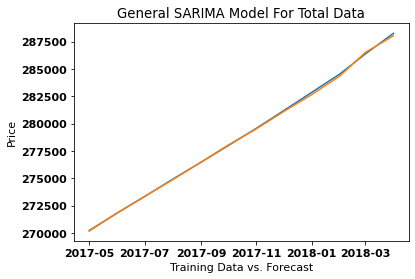

In [74]:
#Get Preds and Map Against y_train

preds = fit_model.get_forecast(steps=12).summary_frame()['mean']

plt.plot(preds)
plt.plot(y_train)

print(f'Mean Absolute Error: {mean_absolute_error(preds, y_train)}')

plt.title('General SARIMA Model For Total Data')
plt.xlabel('Training Data vs. Forecast')
plt.ylabel('Price');


In [24]:
#Creating dataframe to assess future values of all regions

final_df = melt_data(df)

final_df['time'] = pd.to_datetime(final_df['time'])

final_df.set_index('time', inplace=True)

final_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,60657,84654,1,Chicago,IL,Chicago,Cook,334200.0
1996-04-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,235700.0
1996-04-01,77494,91982,3,Katy,TX,Houston,Harris,210400.0
1996-04-01,60614,84616,4,Chicago,IL,Chicago,Cook,498100.0
1996-04-01,79936,93144,5,El Paso,TX,El Paso,El Paso,77300.0
...,...,...,...,...,...,...,...,...
2018-04-01,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,209300.0
2018-04-01,3293,59107,14720,Woodstock,NH,Claremont,Grafton,225800.0
2018-04-01,40404,75672,14721,Berea,KY,Richmond,Madison,133400.0


In [25]:
#Isolating all regions

regions = pd.DataFrame(final_df['RegionID'].value_counts())

#Isolating Regions with complete data sets

complete_regions = regions[regions['RegionID'] == 265]

#Isolating regions that have experienced the most growth in the last years

complete_regions = complete_regions.reset_index()

complete_regions.columns = ['RegionID', 'DataPoints']

annual_growth = complete_regions[['RegionID']]

In [26]:
#Create Columns to Compare Annual growth

annual_growth['Current Year'] = pd.to_datetime('2018-04-01')
annual_growth['Previous Year'] = pd.to_datetime('2017-04-01')

In [27]:
merge_table = final_df.reset_index()

merge_table['time'] = pd.to_datetime(merge_table['time'])

merge_table

,time,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
0,1996-04-01,60657,84654,1,Chicago,IL,Chicago,Cook,334200.0
1,1996-04-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,235700.0
2,1996-04-01,77494,91982,3,Katy,TX,Houston,Harris,210400.0
3,1996-04-01,60614,84616,4,Chicago,IL,Chicago,Cook,498100.0
4,1996-04-01,79936,93144,5,El Paso,TX,El Paso,El Paso,77300.0
...,...,...,...,...,...,...,...,...,...
3744699,2018-04-01,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,209300.0
3744700,2018-04-01,3293,59107,14720,Woodstock,NH,Claremont,Grafton,225800.0
3744701,2018-04-01,40404,75672,14721,Berea,KY,Richmond,Madison,133400.0
3744702,2018-04-01,81225,93733,14722,Mount Crested Butte,CO,NaN,Gunnison,664400.0


In [28]:
# #Joining DataFrames to get current and previous values 

growth_table =  annual_growth.merge(merge_table, 
                           how='inner', left_on=['Current Year', 'RegionID'], right_on=['time', 'RegionID'])

growth_table = growth_table[['Current Year', 'Previous Year', 'RegionID', 'time','value']]

growth_table.columns = ['Current Year', 'Previous Year', 'RegionID', 'time (current year)', 'Current Value']

growth_table = growth_table.merge(merge_table, how='inner',
                                  left_on=['Previous Year', 'RegionID'], right_on=['time', 'RegionID'])

growth_table = growth_table[['RegionID', 'Previous Year', 'Current Year', 'value', 'Current Value']]

growth_table.columns = ['RegionID', 'Previous Year', 'Current Year', 'Previous Value', 'Current Value']

growth_table['Growth'] = growth_table['Current Value'] / growth_table['Previous Value'] - 1

#Isolating Top 20 Regions that Grew between 2017 and 2018

top_regions = growth_table.sort_values(by='Growth', ascending = False).head(100)

top_regions

,RegionID,Previous Year,Current Year,Previous Value,Current Value,Growth
10656,60610,2017-04-01,2018-04-01,123800.0,186700.0,0.508078
6050,66014,2017-04-01,2018-04-01,36800.0,52900.0,0.437500
12044,60607,2017-04-01,2018-04-01,131200.0,188300.0,0.435213
12183,60561,2017-04-01,2018-04-01,141500.0,202000.0,0.427562
8174,73219,2017-04-01,2018-04-01,67200.0,95500.0,0.421131
...,...,...,...,...,...,...
2214,72702,2017-04-01,2018-04-01,87000.0,110800.0,0.273563
6359,98652,2017-04-01,2018-04-01,58500.0,74500.0,0.273504
6740,63882,2017-04-01,2018-04-01,90400.0,115000.0,0.272124
12891,73115,2017-04-01,2018-04-01,86400.0,109900.0,0.271991


In [29]:
#Creating function to get forecast by region

region_melt = melt_data(df)

def get_2019_forecast(Region_ID):

    X_train_region = region_melt[region_melt['RegionID'] == Region_ID]

    X_train_region['time'] = pd.to_datetime(X_train_region['time'])

    X_train_region.set_index('time', inplace = True)

    X_train_region = X_train_region[['value']]

    regional_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train_region,
                                           order = best_pdq,
                                           seasonal_order = best_PDQS,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)

    regional_model_fit = regional_model.fit()

    regional_preds = regional_model_fit.get_forecast(12)

    regional_preds_df = regional_preds.summary_frame()[['mean']]

    return [Region_ID, int(regional_preds_df[regional_preds_df.index == '2019-04-01'][['mean']]['mean'])]

In [30]:
forecasted_values = []

for item in list(top_regions['RegionID']):
    forecasted_values.append(get_2019_forecast(item))

In [31]:
#Isolating top regions by forecast

top_future_regions = pd.DataFrame(forecasted_values)

top_future_regions.columns = ['RegionID', '2019 value']

top_100_forecasted_growth = top_future_regions.merge(growth_table, how='left', on=['RegionID'])

top_100_forecasted_growth['Future Growth'] = (top_100_forecasted_growth['2019 value'] / 
                                              top_100_forecasted_growth['Current Value'] - 1)

#Isolating Top 10 Growers

top_10_growers_df = top_100_forecasted_growth.sort_values('Future Growth', ascending = False).head(10)

top_10_growers = top_100_forecasted_growth.sort_values('Future Growth', ascending = False).head(10)

top_10_growers = list(top_10_growers['RegionID'])

top_10_growers

[99877, 73177, 66015, 60706, 91259, 60642, 92306, 399593, 66828, 70395]

In [51]:
avg_growth = np.average(top_100_forecasted_growth['Future Growth'])

Text(0, 0.5, 'Growth in %')

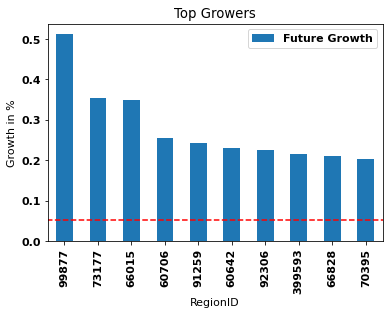

In [75]:
top_10_growers_df.plot(x='RegionID', y='Future Growth', kind='bar')
plt.hlines(avg_growth, xmin=-1, xmax=50, linestyles='dashed', color='red', label='Average Growth')
plt.title('Top Growers')
plt.ylabel('Growth in %')

In [32]:
def region_acc_compute(ID, choice):
    
    region_df = region_melt[region_melt['RegionID'] == ID]

    region_df['time'] = pd.to_datetime(region_df['time'])

    region_df.set_index('time', inplace = True)

    region_df = region_df[['value']]

    X_train = region_df.head(265-12)
    y_train = region_df.tail(12)

    regional_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                           order = best_pdq,
                                           seasonal_order = best_PDQS,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)

    fit_model = regional_model.fit()
    preds = fit_model.get_forecast(steps = 12).summary_frame()['mean']

    mae = mean_absolute_error(preds, y_train)
    comp_error = round(float(mae / preds[-1:]), 2)
    
    if choice == 'stats':
    
        return [ID, mae, comp_error]
    
    else:
        
        return preds

In [34]:
region_acc_df = []

for item in top_10_growers:
    region_acc_df.append(region_acc_compute(item, 'stats'))


In [42]:
#Top 10 Most Accurate

region_acc_df = pd.DataFrame(region_acc_df)

region_acc_df.columns = ['RegionID', 'MAE', 'Comp Error']

most_accurate_growers = region_acc_df.sort_values(by='Comp Error', ascending = True).head(5)

most_accurate_growers

#Add Descriptors to Region

most_accurate_growers = most_accurate_growers.merge(region_melt, how='inner', left_on='RegionID', right_on='RegionID')

most_accurate_growers = most_accurate_growers[['RegionID', 'City', 'State', 'Metro', 'CountyName', 'MAE', 'Comp Error']].drop_duplicates()

most_accurate_growers

most_accurate_growers.to_excel('acc_growers.xlsx')

In [81]:
comp_error_avg = np.average(region_acc_df['Comp Error'])

Text(0.5, 1.0, 'Computational Error for Most Accurate Growers')

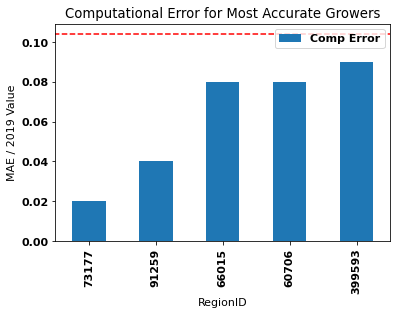

In [85]:
most_accurate_growers.plot('RegionID', 'Comp Error', kind='bar')

plt.hlines(comp_error_avg, xmin=-1, xmax=50, linestyles='dashed', color='red', label='Average Growth')
plt.ylabel('MAE / 2019 Value')
plt.title('Computational Error for Most Accurate Growers')


In [37]:
#Create function to plot each forecast

def plot_top_growers(region):

    test_preds = region_acc_compute(region, 'preds')

    sample_region_df = region_melt[region_melt['RegionID'] == region]

    sample_region_df['time'] = pd.to_datetime(sample_region_df['time'])

    sample_region_df.set_index('time', inplace = True)

    sample_region_df = sample_region_df['value']

    y_train_sample_df = sample_region_df.tail(12)
    
    figure(figsize=(12, 6), dpi=80)

    plt.plot(sample_region_df['2015':], color='black')
    plt.plot(test_preds, color='blue')
    plt.plot(y_train_sample_df='green')
    
#     county = most_accurate_growers[most_accurate_growers['RegionID']==region][['CountyName']]['CountyName'][0]
#     city = most_accurate_growers[most_accurate_growers['RegionID']==region][['City']]['City'][0]
#     state = most_accurate_growers[most_accurate_growers['RegionID']==region][['State']]['State'][0]

    location = f'{region}'

    plt.title(f'Forecast For {location}')
    
    test_preds.to_csv(f'{region}_preds.csv')

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

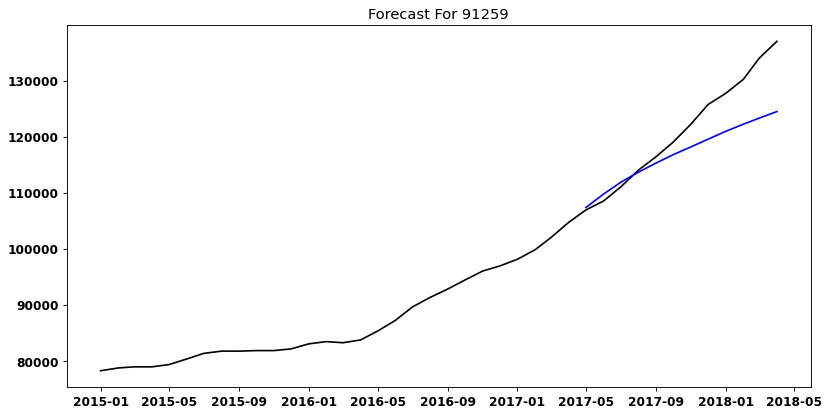

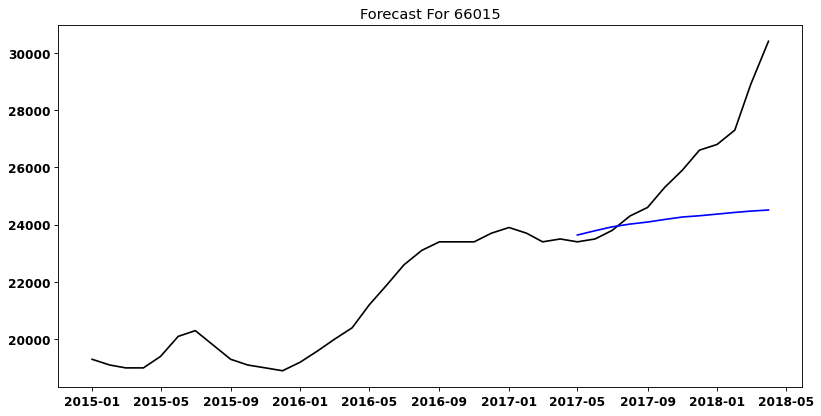

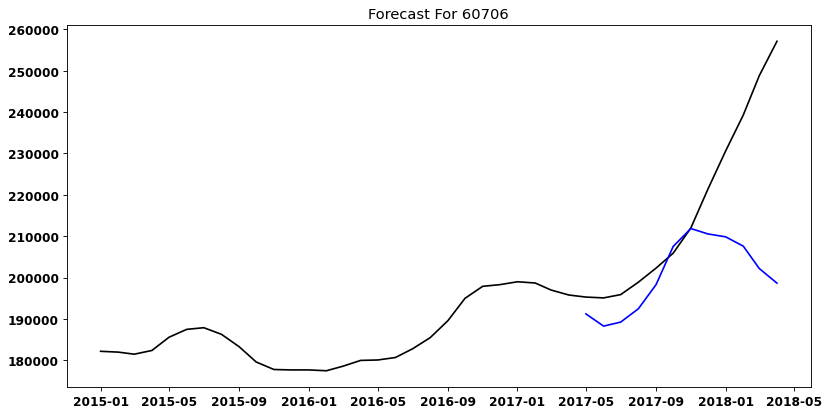

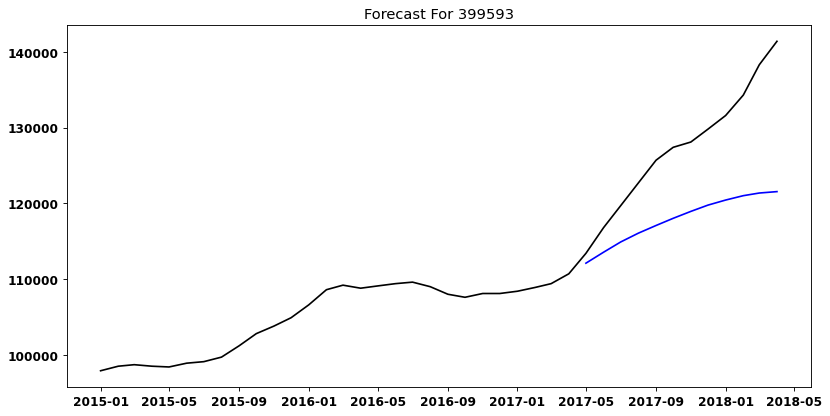

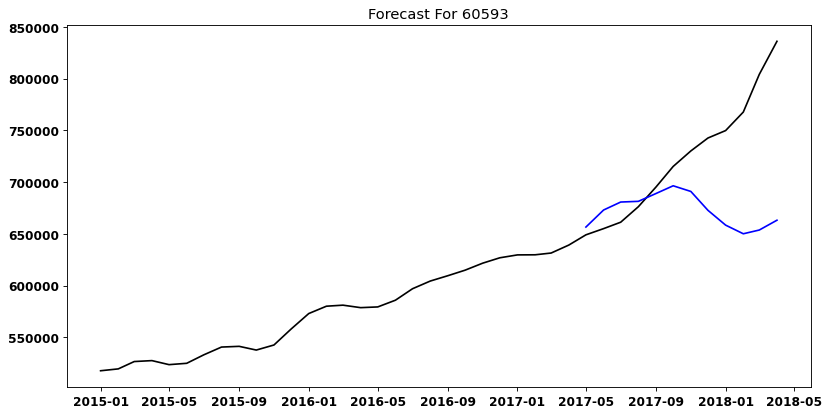

In [38]:
#plot top growers to determine accuracy

for item in list(most_accurate_growers['RegionID']):
    plot_top_growers(item)

# Step 6: Interpreting Results